In [34]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import pycaret.regression as pyr


In [35]:
df = pd.read_csv("consumption_temp.csv")
df['time'] = pd.to_datetime(df['time'])

df.describe()

,consumption,temperature
count,49494.000000,49494.000000
mean,3.509242,6.554019
std,3.096356,7.630308
min,0.000000,-17.299999
25%,1.263256,1.000000
50%,2.376530,6.800000
75%,5.189000,12.100000
max,18.045011,30.500000


In [36]:
import pandas as pd
import numpy as np

df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df['time'].dt.month

df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [37]:
lags = [24, 25, 26, 48, 49, 50, 72]
delay = 120

for lag in lags:
    df[f'load_t-{lag}h'] = df.groupby('location')['consumption'].shift(lag+delay)
    df[f'avg_load_t-{lag}h'] = df['consumption'].shift(lag+delay).expanding().mean()
    df[f'temperature_t-{lag}h'] = df.groupby('location')['temperature'].shift(lag)
    

df.reset_index(inplace=True)

df.dropna(inplace=True)


In [38]:

df['original_location'] = df['location']
df = pd.get_dummies(df, columns=['location'])

In [39]:
last_date = df['time'].max().date()
test_start_date = last_date - timedelta(days=29)

df_0_10 = df[df['hour'] < 10].copy()
df_11_24 = df[df['hour'] >= 10].copy()

from sklearn.model_selection import train_test_split

def split_train_test_randomly(df):
    # Ensure 'time' is in datetime format
    df['time'] = pd.to_datetime(df['time']) 
    
    # Split the data randomly
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    return train_df, test_df


df_0_10 = df[df['hour'] < 10].copy()
df_11_24 = df[df['hour'] >= 10].copy()

# Apply the function to split train and test data randomly
train_0_10, test_0_10 = split_train_test_randomly(df_0_10)
train_11_24, test_11_24 = split_train_test_randomly(df_11_24)


In [40]:

excluded_features = ['time', 'temperature', 'original_location']
excluded_features_11_24 = ['time', 'temperature', 'original_location', 'consumption_t-24h', 'avg_load_t-24h']

pyr.setup(data=train_0_10, target='consumption', ignore_features=excluded_features, session_id=42)
best_model_0_10 = pyr.compare_models()
final_model_0_10 = pyr.finalize_model(best_model_0_10)

pyr.setup(data=train_11_24, target='consumption', ignore_features=excluded_features_11_24, session_id=42)
best_model_11_24 = pyr.compare_models()
final_model_11_24 = pyr.finalize_model(best_model_11_24)

predictions_0_10 = pyr.predict_model(final_model_0_10, data=test_0_10)
predictions_11_24 = pyr.predict_model(final_model_11_24, data=test_11_24)

combined_predictions = pd.concat([predictions_0_10, predictions_11_24]).sort_values(by='time')





,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(16112, 35)"
4,Transformed data shape,"(16112, 32)"
5,Transformed train set shape,"(11278, 32)"
6,Transformed test set shape,"(4834, 32)"
7,Ignore features,3
8,Numeric features,31
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:48:51
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0964,0.0322,0.1791,0.9965,0.0323,0.0357,1.0660
lightgbm,Light Gradient Boosting Machine,0.1432,0.0522,0.2281,0.9944,0.0463,0.0571,0.9910
rf,Random Forest Regressor,0.1299,0.0549,0.2340,0.9941,0.0422,0.0480,2.8330
dt,Decision Tree Regressor,0.1771,0.1189,0.3443,0.9872,0.0632,0.0659,0.0520
gbr,Gradient Boosting Regressor,0.2206,0.1285,0.3579,0.9862,0.0688,0.0825,1.0010
knn,K Neighbors Regressor,0.2378,0.1455,0.3809,0.9843,0.0877,0.1043,0.0320
lr,Linear Regression,0.3659,0.3282,0.5722,0.9648,0.1318,0.1685,0.3940
ada,AdaBoost Regressor,0.4759,0.3538,0.5946,0.9619,0.1821,0.2981,0.3060
br,Bayesian Ridge,0.3651,0.3764,0.6129,0.9596,0.1092,0.1376,0.0140
ridge,Ridge Regression,0.3651,0.3759,0.6124,0.9596,0.1092,0.1376,0.0140


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(22561, 35)"
4,Transformed data shape,"(22561, 31)"
5,Transformed train set shape,"(15792, 31)"
6,Transformed test set shape,"(6769, 31)"
7,Ignore features,5
8,Numeric features,30
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:50:11
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1024,0.0328,0.1804,0.9968,0.0320,0.0347,1.4440
lightgbm,Light Gradient Boosting Machine,0.1483,0.0538,0.2314,0.9947,0.0450,0.0526,1.0500
rf,Random Forest Regressor,0.1335,0.0544,0.2324,0.9946,0.0406,0.0446,3.9280
dt,Decision Tree Regressor,0.1789,0.1170,0.3405,0.9885,0.0587,0.0603,0.0800
knn,K Neighbors Regressor,0.2253,0.1310,0.3613,0.9871,0.0782,0.0890,0.0490
gbr,Gradient Boosting Regressor,0.2231,0.1337,0.3650,0.9868,0.0650,0.0736,1.3310
lr,Linear Regression,0.3346,0.3105,0.5565,0.9695,0.1038,0.1176,0.0310
ridge,Ridge Regression,0.3402,0.3304,0.5740,0.9675,0.0984,0.1128,0.0240
br,Bayesian Ridge,0.3403,0.3309,0.5744,0.9675,0.0985,0.1129,0.0280
ada,AdaBoost Regressor,0.4432,0.3321,0.5760,0.9672,0.1641,0.2397,0.4150


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0741,0.0170,0.1306,0.9979,0.0267,0.0293


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0793,0.0190,0.1379,0.9981,0.0261,0.0282


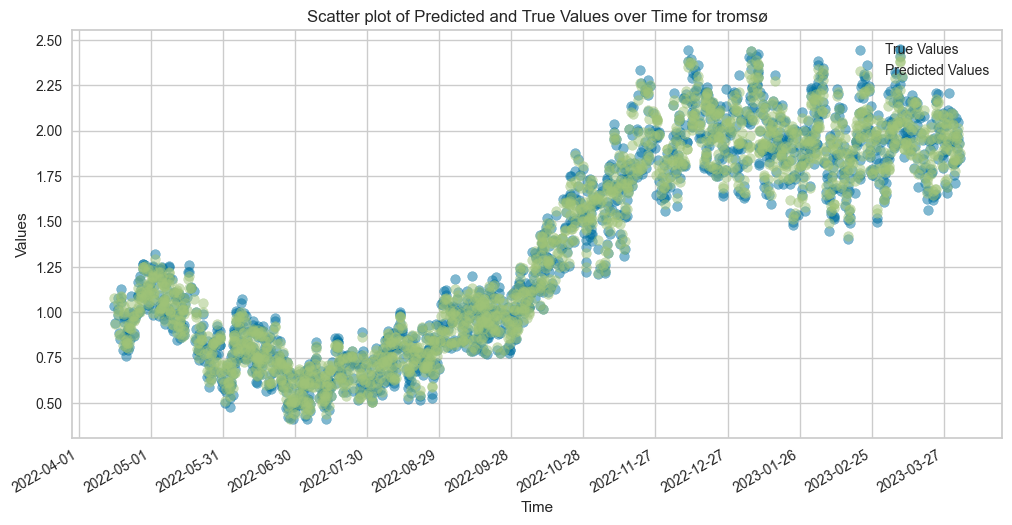

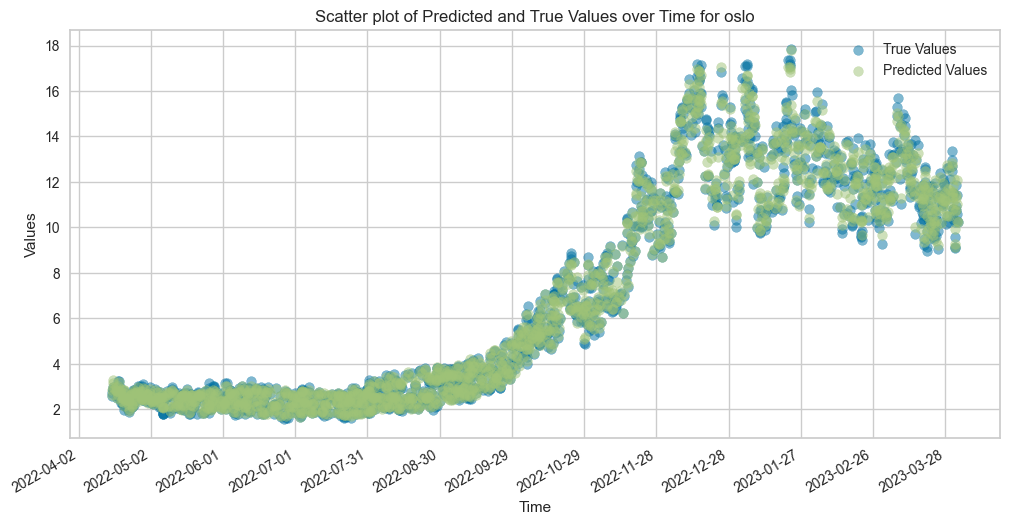

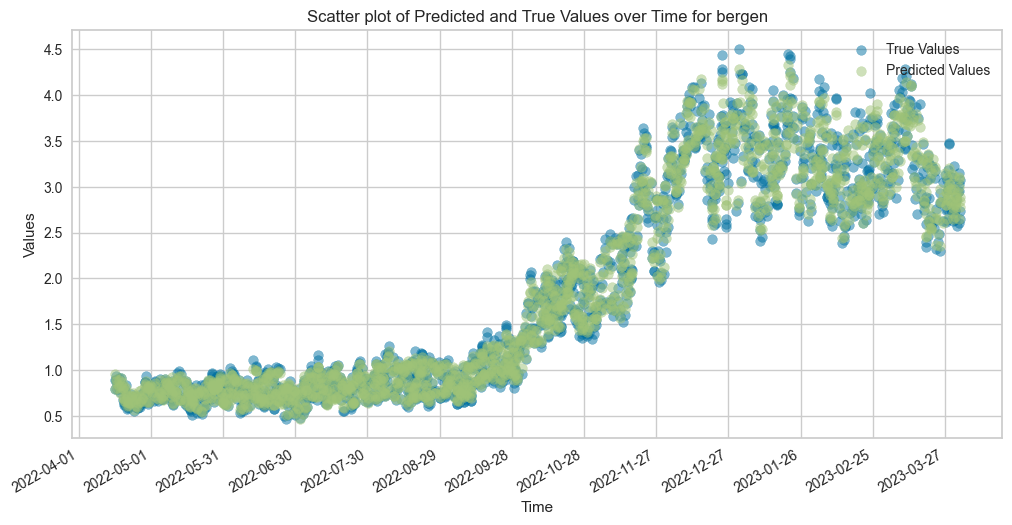

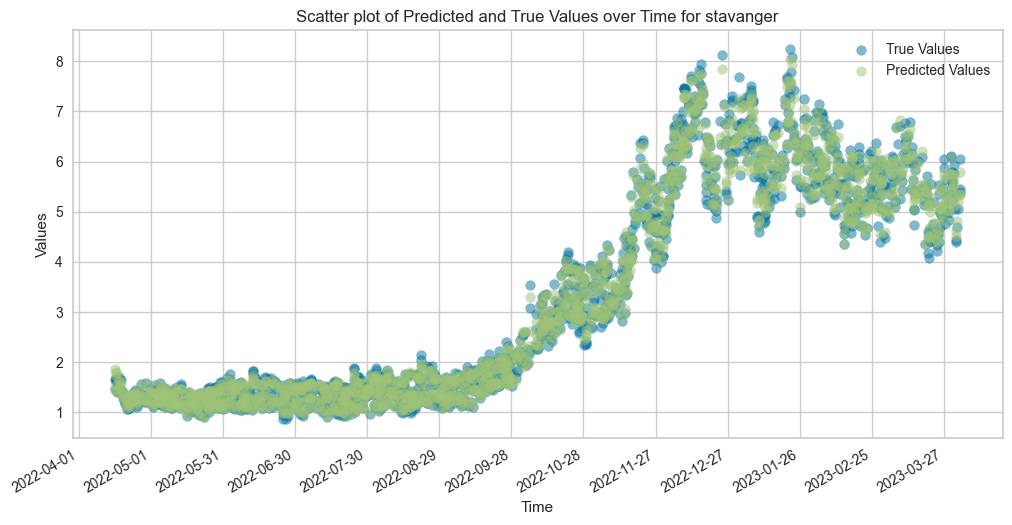

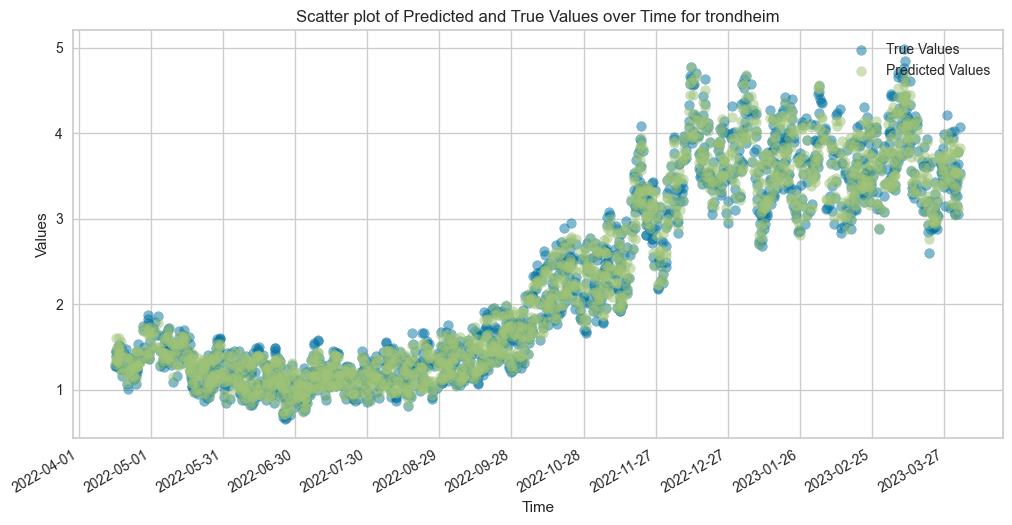

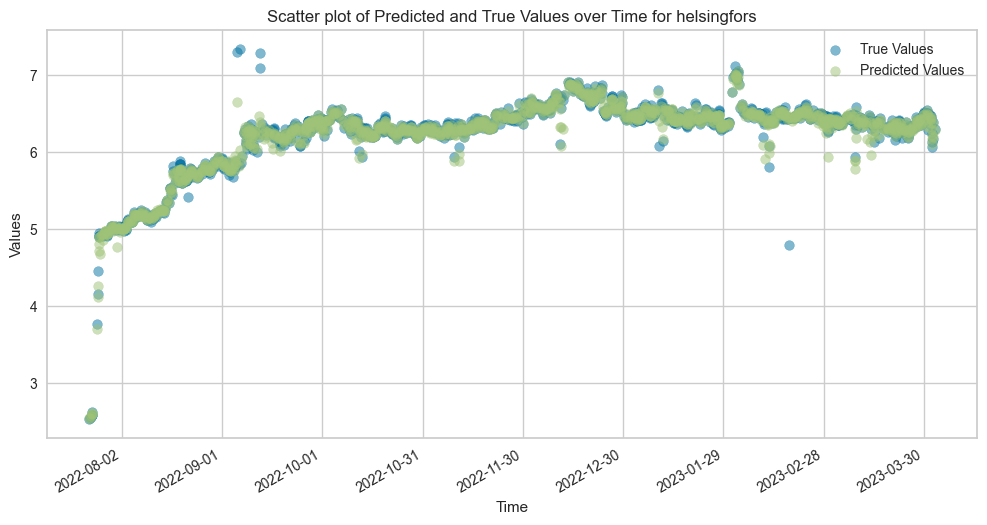

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

locations = combined_predictions['original_location'].unique()

for location in locations:
    plt.figure(figsize=(12, 6))
    
    # Extracting the subset of the DataFrame corresponding to the current location
    subset_df = combined_predictions[combined_predictions['original_location'] == location]
    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    
    plt.scatter(time, true_values, alpha=0.5, label='True Values')
    plt.scatter(time, predicted_values, alpha=0.5, label='Predicted Values')

    # Formatting the x-axis as date
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Adjust interval for readability if needed
    plt.gcf().autofmt_xdate()

    plt.title(f'Scatter plot of Predicted and True Values over Time for {location}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()



In [ ]:
print(final_model_0_10)


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['hour', 'day_of_week',
                                             'is_weekend', 'month',
                                             'load_t-24h', 'avg_load_t-24h',
                                             'temperature_t-24h', 'load_t-25h',
                                             'avg_load_t-25h',
                                             'temperature_t-25h', 'load_t-26h',
                                             'avg_load_t-26h',
                                             'temperature_t-26h', 'load_t-48h',
                                             'avg_load_t-48h',
                                             'temperature_t-48h', 'load_t-49h',
                                             '...
                                             'location_helsingfors',
                                             'location_oslo',
                    

In [29]:
combined_predictions

,time,temperature,hour,day_of_week,is_weekend,month,load_t-24h,avg_load_t-24h,temperature_t-24h,load_t-25h,...,temperature_t-72h,original_location,location_bergen,location_helsingfors,location_oslo,location_stavanger,location_tromsø,location_trondheim,consumption,prediction_label
27,2022-04-30 03:00:00,-1.7,3,5,1,4,0.856395,1.534158,-3.0,0.861467,...,-5.6,tromsø,0,0,0,0,1,0,1.038704,1.060465
6,2022-04-30 03:00:00,3.3,3,5,1,4,0.559368,1.534360,3.1,0.561007,...,3.0,bergen,1,0,0,0,0,0,0.650456,0.656576
34,2022-04-30 03:00:00,4.3,3,5,1,4,1.125387,1.533827,2.0,1.122400,...,0.5,trondheim,0,0,0,0,0,1,1.344174,1.363392
20,2022-04-30 03:00:00,4.6,3,5,1,4,1.052996,1.534134,5.2,1.063048,...,5.1,stavanger,0,0,0,1,0,0,1.176380,1.173522
13,2022-04-30 03:00:00,5.1,3,5,1,4,2.087697,1.534270,4.1,2.111344,...,3.1,oslo,0,0,1,0,0,0,2.319325,2.325000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2023-04-02 21:00:00,0.5,21,6,1,4,5.593681,3.504260,1.0,5.907937,...,3.0,stavanger,0,0,0,1,0,0,5.622820,5.544589
497,2023-04-02 21:00:00,-1.1,21,6,1,4,12.332533,3.504230,-2.6,13.023539,...,-0.5,oslo,0,0,1,0,0,0,12.134655,11.979228
518,2023-04-02 21:00:00,-3.8,21,6,1,4,3.778816,3.504231,-2.7,3.926530,...,-6.5,trondheim,0,0,0,0,0,1,3.749047,3.770291
490,2023-04-02 21:00:00,-1.1,21,6,1,4,6.393000,3.504074,-1.0,6.399000,...,-1.7,helsingfors,0,1,0,0,0,0,6.333000,6.353120
